# 적대적 공격
딥러닝 모델의 약점을 발견하는 방법을 알아보고 이를 통해 직접 해킹 시도

## 적대적 공격의 종류
적대적 공격은 적절한 잡음(노이즈)를 생성하여 사람의 눈에는 똑같이 보이지만, 머신러닝 모델을 헷갈리게 만드는 적대적 예제를 생성하는 것
<br>적대적 예제에서 잡음의 생성 방법은 분류기준이 무엇이냐에 따라 여러가지로 나뉨
1. 기울기와 같은 모델 정보가 필요한지에 따라, 모델 정보를 토대로 잡음을 생성하는 **화이트박스**방법과 모델 정보 없이 생성하는 **블랙박스**방법으로 나뉨
2. 원하는 정답으로 유도할 수 있다면 **표적** 아니라면 **비표적**으로 분류
3. 잡음을 생성하기 위해 반복된 학습(최적화)이 필요하면 **반복**, 아니라면 **원샷** 
4. 한 잡음이 특정 입력에만 적용되는지, 혹은 모든 이미지에 적용될 수 있는 범용적인 잡음인지

**가장 강력한 공격 방법은 모델 정보가 필요없고, 원하는 정답으로 유도할 수 있고, 복잡한 학습이 필요하지 않으며, 여러 모델에 동시에 적용할 수 있는 방법**

## FGSM(fast gradient sign method) 공격
- 반복된 학습 없이 잡음을 생성하는 원샷 공격으로, **입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성**
- 공격 목표를 정할 수 없는 **non-targeted** 방식이자, 대상 모델의 정보가 필요한 **whitebox** 방식

In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\woojung\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#학습된 모델 불러오기
model = models.resnet101(pretrained = True) #DenseNet이나 Inceeption v3같은 모델 사용 가능
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
#데이터 셋 불러오기
#숫자와 클래스 제목의 매칭 정보가 들어가 있음
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)]for i in range(1000)]

In [4]:
#이미지 불러오기
img = Image.open('imagenet_samples/corgie.jpg')

In [5]:
#이미지를 텐서로 변환
## ImageNet과 같은 크기인 224*224로 바꿈
img_transforms = transforms.Compose([
    transforms.Resize((224,224), Image.BICUBIC),
    transforms.ToTensor(),
])

In [6]:
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)
# (3*224*224 -> 1*3*224*224)
print("이미지 텐서 모양:", img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


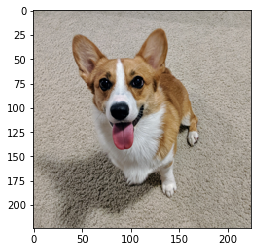

In [7]:
#시각화를 위해 넘파이 행렬 변환
# [1,,3,224,224] -> [3,224,224]
original_img_view = img_tensor.squeeze(0).detach() #시각화를 위하여 다시 squeeze #detach() 함수를 사용하여 원본 이미지 텐서와의 연결을 끊어버림
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy() #transpose함수를 통해 뒤집힌 이미지를 제자리로
#matplotlib과 호환되는 넘파이 행렬로 만들기 위하여 numpy행렬 호출
plt.imshow(original_img_view)

In [8]:
#pretrained model resnet101의 분류
output = model(img_tensor)
prediction = output.max(1,keepdim = False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:",prediction_name)

예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


## FGSM 공격 함수
- 모델에서 입력 이미지에 대한 기울기 정보를 추출하고, 그것을 왜곡하여 원본 이미지에 더하는 것
- 기울기는 모델이 학습할 때 각 픽셀에 미치는 영향
- 원본 이미지를 받아 적대적 예제를 생성하는 **fgsm_attack()함수**를 정의 
<br>
<br>
모델을 헷갈리게 하려면 모델의 오찻값을 극대화해야 함
- 딥러닝 모델을 학습할 때는 기울기의 정반대 편으로 가중치를 조절하며 오차를 줄임
- FGSM공격에선 반대로 잡음이 **기울기 방향으로 최적화하도록 해서 오차를 키움**
- 따라서 기울기의 방향성을 알 수 있도록 **sign()함수** 적용
- **sign() 함수**는 입력이 0보다 작으면 -1, 0이면 0, 0보다 크면 1을 출력하는 단순한 함수
<br>
<br>
- 작은 값인 **앱실론**을 곱해줌
- 앱실론은 모델 학습 시 지정해줘야 하는 학습률과 같은 개념
- 잡음이 너무 커지지 않고 사람의 눈에 보이지 않게 제한하는 역할
- 이미지의 기울기 방향이 양수인 곳에 앱실론 만큼 값이 증가시키고, 음수인 곳은 앱실론 만큼 값을 감소시킴

<br>
<br>
##### 정리: fgsm_attack()함수는 원본이미지에서 적대적 예제를 생성하는 함수, FGSM공격에서는 잡음이 기울기 방향으로 최적화하도록 오차를 키운다. sign함수를 통하여 기울기의 방향성 확인, 앱실론은 사람의 눈에 보이지 않게 제한하는 역할 ######

In [9]:
def fgsm_attack(image, epsilon, gradient):
    #기울깃값의 원소로 sign값을 구함
    sign_gradient = gradient.sign()
    
    #이미지의 각 픽셀 값을 sign_gradient 방향으로 epsilon만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    
    #[0,1] 범위를 벗어나는 값 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

##### model에 이미지를 돌린 후 역전파를 사용하여 기울기를 구하기(본래 모델 돌리는 것과 동일)

In [20]:
#이미지의 기울기를 구하도록 설정
img_tensor.requires_grad_(True) #기울기 보존

#이미지를 모델에 통과시킴
output = model(img_tensor)

#오찻값 구하기(번호 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263]))

#기울기 구하기
model.zero_grad()
loss.backward()

#### 역적파 #####

##### 구한 gradient을 사용하여 적대적 예제 생성

In [12]:
#이미지의 기울기 추출
gradient = img_tensor.grad.data #입력 이미지의 기울기가 저장 

#FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [14]:
#생성된 적대적예제에 모델 통과
output = model(perturbed_data)

#### 적대적 예제 성능 확인

In [16]:
perturbed_prediction = output.max(1,keepdim = True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:",perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 172
레이블 이름: whippet


## 적대적 예제 시각화

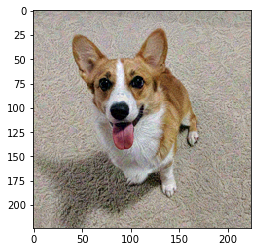

In [17]:
#시각화를 위한 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view .transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

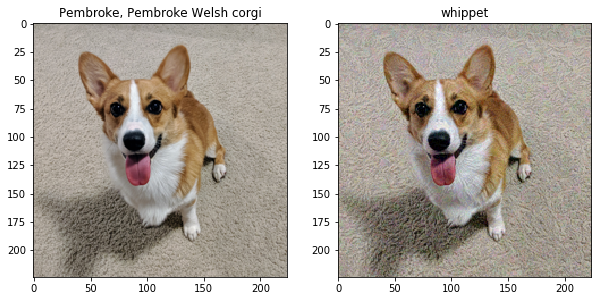

In [19]:
##사실 이미지 주변에 이상한 무늬가 생겼지만 사람의 눈에는 여전히 웰시코기로 보임
f,a = plt.subplots(1,2,figsize = (10,10))

#원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

#적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()